In [40]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import lightgbm as lgb
import datetime
from sklearn.model_selection import train_test_split

In [41]:
flow = pd.read_csv("flow_train.csv")
# transition = pd.read_csv("transition_train.csv")

In [42]:
districts = sorted(flow.district_code.unique())
dates = sorted(flow.date_dt.unique())
cities = sorted(flow.city_code.unique())
d2c = dict(np.array((flow[[ 'district_code', 'city_code']].drop_duplicates())))
def dateStrlist(year,month, day, lenth):
    result = []
    for i in range(lenth):
        init_date = datetime.date(year, month, day)
        _date = init_date + datetime.timedelta(days=i)
        result.append(_date.strftime('%Y%m%d'))
    return result

In [43]:
trans = flow.copy()
trans['date_dt'] = trans['date_dt'].apply(lambda x: dates.index(x))
trans['district_code'] = trans['district_code'].apply(lambda x: districts.index(x))
trans['city_code'] = trans['city_code'].apply(lambda x: cities.index(x))

In [44]:
df = pd.DataFrame()
for d in range(len(districts)):
    dwell = np.log(np.array(trans[trans.district_code == d].sort_values(by = 'date_dt')['dwell'] + 1))
    flow_in = np.log(np.array(trans[trans.district_code == d].sort_values(by = 'date_dt')['flow_in'] + 1))
    flow_out = np.log(np.array(trans[trans.district_code == d].sort_values(by = 'date_dt')['flow_out'] + 1))
    df['dwell%d_b0'%d] = dwell
    df['flow_in%d_b0'%d] = flow_in
    df['flow_out%d_b0'%d] = flow_out
    for i in range(1, 30):
        df['dwell%d_b%d'%(d, i)]  = [*np.zeros(i), *dwell[:-i]]
        df['flow_in%d_b%d'%(d, i)]  = [*np.zeros(i), *flow_in[:-i]]
        df['flow_out%d_b%d'%(d, i)]  = [*np.zeros(i), *flow_out[:-i]]

In [45]:
for i in range(7):
    df["w%d"%i] = np.array(np.array(range(len(df)))%7 == i).astype(np.int8)
    
df["md"] = np.array(np.array(range(len(df)))%30)
df["mm"] = np.array(np.array(range(len(df)))//30)

In [122]:
def featureExtractor(fe, dist, col):
    nfe = pd.DataFrame()
    for j in range(1, 30):
        copy_col = "%s%d_b%d"%(col, dist, j)
        nfe[copy_col] = fe[copy_col]
        # 一阶差分
        if j > 0:
            nfe["delt%d_%d"%(j-1, j)] = fe['%s%d_b%d'%(col, dist, j-1)] - fe['%s%d_b%d'%(col, dist, j)]
        
        # 二阶差分
        if j > 1:
            nfe["delt%d_%d"%(j-2, j)] = fe['%s%d_b%d'%(col, dist, j-2)] + fe['%s%d_b%d'%(col, dist, j)] - 2*fe['%s%d_b%d'%(col, dist, j-1)]
        
        # 三阶差分
        if j > 2:
            nfe["delt%d_%d"%(j-3, j)] = fe['%s%d_b%d'%(col, dist, j-3)] - 3*fe['%s%d_b%d'%(col, dist, j-2)] + 3*fe['%s%d_b%d'%(col, dist, j-1)] - fe['%s%d_b%d'%(col, dist, j)]
    
    # 统计特征
    for span in [3,7,15,30]:
        columns = ['%s%d_b%d'%(col, dist, j) for j in range(span)]
        nfe["max%d"%span] = fe[columns].max(axis = 1)
        nfe["min%d"%span] = fe[columns].min(axis = 1)
        nfe["mean%d"%span] = fe[columns].mean(axis = 1)
        nfe["std%d"%span] = fe[columns].std(axis = 1)
    
    
    for i in range(7):
        nfe["w%d"%i] = fe["w%d"%i]
            
    for i in range(98):
        nfe["%s%d_b0"%(col, i)] = fe["%s%d_b0"%(col, i)]
        
    nfe['md'] = fe['md']
    nfe['mm'] = fe['mm']

    return nfe

# 分别建模预测

In [ ]:
# 这里我们先拿前30天的数据 分别预测 1-15天后的数据。
# 后续可以尝试 今日预测1天后的，和2天谴预测2天后的，以此类推。多日模型进行融合。

for col in ['dwell', 'flow_in', 'flow_out']:
    dataDf = pd.DataFrame()
    for d in range(len(districts)):
        for span in range(1,16):
            start_index = 30
            predict_span = span
            label = df["%s%d_b0"%(col,d)][start_index + predict_span:]
            feature = df[start_index:-predict_span]
            feature = featureExtractor(feature, d, col)
            feature['y'] = label.tolist()
            test_x = featureExtractor(df[-1:], d, col)
            test_x['y'] = -1
            colDf = feature.append(test_x)
            colDf['district'] = districts[d]
            colDf['city'] = d2c[districts[d]]
            colDf['span'] = span
            dataDf = dataDf.append(colDf)
        print(end = ".")
    dataDf.to_csv("%s.csv"%col, index = None)
    print("\n", span)

..................................................................................................
 15
.....................................................................

In [ ]:
predicts = None
scores = []
for col in ['dwell', 'flow_in', 'flow_out']:
    tdf = pd.read_csv("%s.csv"%col)
    tdf['city'] = tdf['city'].astype("category")
    tdf['district'] = tdf['district'].astype("category")
    train = tdf[tdf.y != -1]
    test = tdf[tdf.y == -1]
    feature = train.drop(['y'], axis = 1)
    label = train['y']
    test_x = test.drop(['y'], axis = 1)
    train_x, eval_x, train_y, eval_y = train_test_split(feature, label, test_size = 0.2)
    if col != 'dwell':
        train_x2 = train_x.copy()
        augRatio = (np.random.random(len(train_y)) - 0.5)/50 + 1
        train_y2 = train_y*augRatio
        train_x = train_x.append(train_x2)
        train_y = train_y.append(train_y2)
    lgbr = lgb.LGBMRegressor(n_jobs = -1, learning_rate = 0.05, num_leaves = 33, subsample = 0.93, random_state = 2018, n_estimators = 1000, colsample_bytree = 0.63, min_child_samples = 20, objective ="regression")
    lgbr.fit(train_x, train_y, eval_set = (eval_x, eval_y), early_stopping_rounds = 20, verbose  = False, eval_metric = 'rmse')
    pred = lgbr.predict(eval_x)
    print(col, np.sqrt(np.mean(np.square(pred - eval_y))), end = '\t')
    scores.append(np.mean(np.square(pred - eval_y)))
    cols = ['span', 'city', 'district']
    test_x = test_x.sort_values(by = cols)
    pred = np.exp(lgbr.predict(test_x))-1
    if predicts is None:
        predicts = test_x[cols].copy()
        predicts[col] = pred
    else:
        predicts[col] = pred
        
datelist = dateStrlist(2018,3, 2, 15)
predicts['date_dt'] = predicts['span'].apply(lambda x: datelist[x-1])
predicts[['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']].to_csv("lgb_predict.csv", index=None, header = None)
print(np.sqrt(np.mean(scores)))

In [119]:
#dwell 0.1119909081030038	flow_in 0.15038583129884533	flow_out 0.1491799408818829	0.13833837321907744

In [120]:
print(np.sqrt(np.mean(scores)))

0.13833837321907744


In [116]:
a = (np.random.random(10) - 0.5)/50 + 1
b = np.arange(10)
c = a*b
c

array([0.        , 1.00958916, 1.98071799, 3.01505825, 3.96792011,
       4.9501849 , 6.02715563, 7.02068294, 8.02263351, 9.08733375])

In [54]:
pred_df = pd.DataFrame(pred_result)
datelist = dateStrlist(2018,3, 2, 15)
pred_df.columns = ['date_dt', 'district', 'dwell', 'flow_in', 'flow_out']
pred_df['date_dt'] = pred_df['date_dt'].apply(lambda x: datelist[x-1])
pred_df['district'] = pred_df['district'].apply(lambda x: districts[x])
pred_df['city'] = pred_df.district.apply(lambda x: d2c[x])
pred_df['dwell'] = pred_df.dwell.apply(lambda x: np.exp(x)-1)
pred_df['flow_in'] = pred_df.flow_in.apply(lambda x: np.exp(x)-1)
pred_df['flow_out'] = pred_df.flow_out.apply(lambda x: np.exp(x)-1)
save_df = pred_df[['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']]
save_df.to_csv("predict112703.csv", header = None, index = None)

In [89]:
lgbdf = pd.read_csv("predict112703.csv", header = None)
arimadf = pd.read_csv("prediction1.csv", header = None)
arimadf.columns = ['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']
lgbdf.columns = ['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']
mdf = pd.merge(lgbdf, arimadf, how='left', on = ['date_dt', 'city', 'district'])
mdf['dwell'] = mdf[['dwell_x', 'dwell_y']].mean(axis = 1)
mdf['flow_in'] = mdf[['flow_in_x', 'flow_in_y']].mean(axis = 1)
mdf['flow_out'] = mdf[['flow_out_x', 'flow_out_y']].mean(axis = 1)
mdf[['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']].to_csv("merge112703.csv", header = None, index = None)

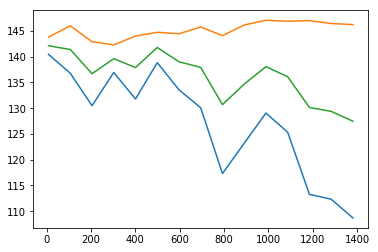

In [109]:
district = districts[i]
plt.plot(mdf[mdf.district == district]['dwell_x'])
plt.plot(mdf[mdf.district == district]['dwell_y'])
plt.plot(mdf[mdf.district == district]['dwell'])
i = (i + 1)%98